# Crocoddyl: Contact RObot COntrol by Differential DYnamic programming Library


## I. Welcome to crocoddyl
Crocoddyl is an **optimal control library for robot control under contact sequence**. Its solver is based on an efficient Differential Dynamic Programming (DDP) algorithm. Crocoddyl computes optimal trajectories along with optimal feedback gains. It uses Pinocchio for fast computation of robot dynamics and its analytical derivatives. 

Crocoddyl is focused on multi-contact optimal control problem (MCOP) which as the form:

$$\mathbf{X}^*,\mathbf{U}^*=
\begin{Bmatrix} \mathbf{x}^*_0,\cdots,\mathbf{x}^*_N \\
				  \mathbf{u}^*_0,\cdots,\mathbf{u}^*_N
\end{Bmatrix} =
\arg\min_{\mathbf{X},\mathbf{U}} \sum_{k=1}^N \int_{t_k}^{t_k+\Delta t} l(\mathbf{x},\mathbf{u})dt$$
subject to
$$ \mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}),$$
$$ \mathbf{x}\in\mathcal{X}, \mathbf{u}\in\mathcal{U}, \boldsymbol{\lambda}\in\mathcal{K}.$$
where
 - the state $\mathbf{x}=(\mathbf{q},\mathbf{v})$ lies in a manifold, e.g. Lie manifold $\mathbf{q}\in SE(3)\times \mathbb{R}^{n_j}$, $n_j$ being the number of degrees of freedom of the robot.
 - the system has underactuacted dynamics, i.e. $\mathbf{u}=(\mathbf{0},\boldsymbol{\tau})$,
 - $\mathcal{X}$, $\mathcal{U}$ are the state and control admissible sets, and
 - $\mathcal{K}$ represents the contact constraints.
 
 Note that $\boldsymbol{\lambda}=\mathbf{g}(\mathbf{x},\mathbf{u})$ denotes the contact force, and is dependent on the state and control.
 
Let's start by understanding the concept behind crocoddyl design.

# II. Action models

In crocoddyl, an action model combines dynamics and cost models. Each node, in our optimal control problem, is described through an action model. In order to describe a problem, we need to provide ways of computing the dynamics, the cost functions and their derivatives. All these are described inside the action model.

To understand the mathematical aspects behind an action model, let's first get a locally linearize version of our optimal control problem as:

$$\mathbf{X}^*(\mathbf{x}_0),\mathbf{U}^*(\mathbf{x}_0)
=
\arg\max_{\mathbf{X},\mathbf{U}} = cost_T(\delta\mathbf{x}_N) + \sum_{k=1}^N cost_t(\delta\mathbf{x}_k, \delta\mathbf{u}_k)$$
subject to
$$dynamics(\delta\mathbf{x}_{k+1},\delta\mathbf{x}_k,\delta\mathbf{u}_k)=\mathbf{0},$$

where
$$cost_T(\delta\mathbf{x}) = \frac{1}{2}
\begin{bmatrix} 
  1 \\ \delta\mathbf{x}
\end{bmatrix}^\top
\begin{bmatrix}
0 & \mathbf{l_x}^\top \\
\mathbf{l_x} & \mathbf{l_{xx}}
\end{bmatrix}
\begin{bmatrix}
  1 \\ \delta\mathbf{x}
\end{bmatrix}
$$

$$cost_t(\delta\mathbf{x},\delta\mathbf{u}) = \frac{1}{2}
\begin{bmatrix} 
  1 \\ \delta\mathbf{x} \\ \delta\mathbf{u}
\end{bmatrix}^\top
\begin{bmatrix}
0 & \mathbf{l_x}^\top & \mathbf{l_u}^\top\\
\mathbf{l_x} & \mathbf{l_{xx}} & \mathbf{l_{ux}}^\top\\
\mathbf{l_u} & \mathbf{l_{ux}} & \mathbf{l_{uu}}
\end{bmatrix}
\begin{bmatrix}
  1 \\ \delta\mathbf{x} \\ \delta\mathbf{u}
\end{bmatrix}
$$

$$
dynamics(\delta\mathbf{x}_{k+1},\delta\mathbf{x}_k,\delta\mathbf{u}_k) = \delta\mathbf{x}_{k+1} - (\mathbf{f_x}\delta\mathbf{x}_k + \mathbf{f_u}\delta\mathbf{u}_k)
$$

where an action model defines a time interval of this problem:
 - $actions = dynamics + cost$

### Important notes:
 - An action model describes the dynamics and cost functions for a node in our optimal control problem.
 - Action models lie in the discrete time space.
 - For debugging and prototyping, we have also implemented numerical differentiation (NumDiff) abstractions. These computations depend only on the definition of the dynamics equation and cost functions. However to asses efficiency, crocoddyl uses **analytical derivatives** computed from Pinocchio.


## II.a Differential and Integrated Action Models
Optimal control solvers require the time-discrete model of the cost and the dynamics. However, it's often convenient to implement them in continuous time (e.g. to combine with abstract integration rules). In crocoddyl, this continuous-time action models are called "Differential Action Model (DAM)". And together with predefined "Integrated Action Models (IAM)", it possible to retrieve the time-discrete action model.

At the moment, we have:
 - a simpletic Euler and
 - a Runge-Kutte 4 integration rules.

An optimal control problem can be written from a set of DAMs as:
$$\mathbf{X}^*(\mathbf{x}_0),\mathbf{U}^*(\mathbf{x}_0)
=
\arg\max_{\mathbf{X},\mathbf{U}} = cost_T(\delta\mathbf{x}_N) + \sum_{k=1}^N \int_{t_k}^{t_k+\Delta t} cost_t(\delta\mathbf{x}_k, \delta\mathbf{u}_k) dt$$
subject to
$$dynamics(\delta\mathbf{x}_{k+1},\delta\mathbf{x}_k,\delta\mathbf{u}_k)=\mathbf{0},$$

where
$$cost_T(\delta\mathbf{x}) = \frac{1}{2}
\begin{bmatrix} 
  1 \\ \delta\mathbf{x}
\end{bmatrix}^\top
\begin{bmatrix}
0 & \mathbf{l_x}^\top \\
\mathbf{l_x} & \mathbf{l_{xx}}
\end{bmatrix}
\begin{bmatrix}
  1 \\ \delta\mathbf{x}
\end{bmatrix}
$$

$$cost_t(\delta\mathbf{x},\delta\mathbf{u}) = \frac{1}{2}
\begin{bmatrix} 
  1 \\ \delta\mathbf{x} \\ \delta\mathbf{u}
\end{bmatrix}^\top
\begin{bmatrix}
0 & \mathbf{l_x}^\top & \mathbf{l_u}^\top\\
\mathbf{l_x} & \mathbf{l_{xx}} & \mathbf{l_{ux}}^\top\\
\mathbf{l_u} & \mathbf{l_{ux}} & \mathbf{l_{uu}}
\end{bmatrix}
\begin{bmatrix}
  1 \\ \delta\mathbf{x} \\ \delta\mathbf{u}
\end{bmatrix}
$$

$$
dynamics(\delta\mathbf{\dot{x}},\delta\mathbf{x},\delta\mathbf{u}) = \delta\mathbf{\dot{x}} - (\mathbf{f_x}\delta\mathbf{x} + \mathbf{f_u}\delta\mathbf{u})
$$

### Building a differential action model for robot forward dynamics
#### Loading the robot

Crocoddyl offers several robot models for benchmarking our optimal control solvers (e.g. manipulators, humanoids, quadrupeds, etc). The collection of Talos models can be downloaded in Ubuntu with the APT package *robotpkg-talos-data*.

Let's load a single Talos arm (left one):

In [1]:
import crocoddyl
import numpy as np
import example_robot_data

talos_arm = example_robot_data.load('talos_arm')
robot_model = talos_arm.model # getting the Pinocchio model

# Defining a initial state
q0 = np.array([0.173046, 1., -0.52366, 0., 0., 0.1, -0.005])
x0 = np.concatenate([q0, np.zeros(talos_arm.model.nv)])

### calc and calcDiff
Optimal control solvers often need to compute a quadratic approximation of the action model (as previously described); this provides a search direction (computeDirection). Then it's needed to try the step along this direction (tryStep).

Typically calc and calcDiff do the precomputations that are required before computeDirection and tryStep respectively (inside the solver). These functions update the information of:
 - **calc**: update the next state and its cost value
 $$\delta\mathbf{\dot{x}}_{k+1} = \mathbf{f}(\delta\mathbf{x}_k,\mathbf{u}_k)$$
 - **calcDiff**: update the derivatives of the dynamics and cost (quadratic approximation)
 $$\mathbf{f_x}, \mathbf{f_u} \hspace{1em} (dynamics)$$
 $$\mathbf{l_x}, \mathbf{l_u}, \mathbf{l_{xx}}, \mathbf{l_{ux}}, \mathbf{l_{uu}} \hspace{1em} (cost)$$
 
 **Crocoddyl put all information inside data**, so avoiding dynamic reallocation.

In [2]:
import pinocchio


class DifferentialFwdDynamics(crocoddyl.DifferentialActionModelAbstract):
    def __init__(self, state, costModel):
        crocoddyl.DifferentialActionModelAbstract.__init__(self, state, state.nv, costModel.nr)
        self.costs = costModel
        self.enable_force = True
        self.armature = np.zeros(0)

    def calc(self, data, x, u=None):
        if u is None:
            u = self.unone
        q, v = x[:self.state.nq], x[-self.state.nv:]
        # Computing the dynamics using ABA or manually for armature case
        if self.enable_force:
            data.xout = pinocchio.aba(self.state.pinocchio, data.pinocchio, q, v, u)
        else:
            pinocchio.computeAllTerms(self.state.pinocchio, data.pinocchio, q, v)
            data.M = data.pinocchio.M
            if self.armature.size == self.state.nv:
                data.M[range(self.state.nv), range(self.state.nv)] += self.armature
            data.Minv = np.linalg.inv(data.M)
            data.xout = data.Minv * (u - data.pinocchio.nle)
        # Computing the cost value and residuals
        pinocchio.forwardKinematics(self.state.pinocchio, data.pinocchio, q, v)
        pinocchio.updateFramePlacements(self.state.pinocchio, data.pinocchio)
        self.costs.calc(data.costs, x, u)
        data.cost = data.costs.cost

    def calcDiff(self, data, x, u=None):
        q, v = x[:self.state.nq], x[-self.state.nv:]
        if u is None:
            u = self.unone
        if True:
            self.calc(data, x, u)
        # Computing the dynamics derivatives
        if self.enable_force:
            pinocchio.computeABADerivatives(self.state.pinocchio, data.pinocchio, q, v, u)
            data.Fx = np.hstack([data.pinocchio.ddq_dq, data.pinocchio.ddq_dv])
            data.Fu = data.pinocchio.Minv
        else:
            pinocchio.computeRNEADerivatives(self.state.pinocchio, data.pinocchio, q, v, data.xout)
            data.Fx = -np.hstack([data.Minv * data.pinocchio.dtau_dq, data.Minv * data.pinocchio.dtau_dv])
            data.Fu = data.Minv
        # Computing the cost derivatives
        self.costs.calcDiff(data.costs, x, u)

    def set_armature(self, armature):
        if armature.size is not self.state.nv:
            print('The armature dimension is wrong, we cannot set it.')
        else:
            self.enable_force = False
            self.armature = armature.T

    def createData(self):
        data = crocoddyl.DifferentialActionModelAbstract.createData(self)
        data.pinocchio = pinocchio.Data(self.state.pinocchio)
        data.multibody = crocoddyl.DataCollectorMultibody(data.pinocchio)
        data.costs = self.costs.createData(data.multibody)
        data.costs.shareMemory(data) # this allows us to share the memory of cost-terms of action model
        return data

## II.b State and its integrate and difference rules
General speaking, the system's state can lie in a manifold $M$ where the state rate of change lies in its tangent space $T_\mathbf{x}M$. There are few operators that needs to be defined for different rutines inside our solvers:
  - $\mathbf{x}_{k+1} = integrate(\mathbf{x}_k,\delta\mathbf{x}_k) = \mathbf{x}_k \oplus \delta\mathbf{x}_k$
  - $\delta\mathbf{x}_k = difference(\mathbf{x}_{k+1},\mathbf{x}_k) = \mathbf{x}_{k+1} \ominus \mathbf{x}_k$

where $\mathbf{x}\in M$ and $\delta\mathbf{x}\in T_\mathbf{x} M$.
 

And we also need to defined the Jacobians of these operators with respect to the first and second arguments:
  - $\frac{\partial \mathbf{x}\oplus\delta\mathbf{x}}{\partial \mathbf{x}}, \frac{\partial \mathbf{x}\oplus\delta\mathbf{x}}{\partial\delta\mathbf{x}} =Jintegrante(\mathbf{x},\delta\mathbf{x})$
  - $\frac{\partial\mathbf{x}_2\ominus\mathbf{x}_2}{\partial \mathbf{x}_1}, \frac{\partial \mathbf{x}_2\ominus\mathbf{x}_1}{\partial\mathbf{x}_1} =Jdifference(\mathbf{x}_2,\mathbf{x}_1)$

For instance, a state that lies in the Euclidean space will the typical operators:
  - $integrate(\mathbf{x},\delta\mathbf{x}) = \mathbf{x} + \delta\mathbf{x}$
  - $difference(\mathbf{x}_2,\mathbf{x}_1) = \mathbf{x}_2 - \mathbf{x}_1$
  - $Jintegrate(\cdot,\cdot) = Jdifference(\cdot,\cdot) = \mathbf{I}$
  

These defines inare encapsulate inside the State class. **For Pinocchio models, we have implemented the StatePinocchio class which can be used for any robot model**.

# III. Solving optimal control problems with DDP

## III.a ABA dynamics for reaching a goal with Talos arm

Our optimal control solver interacts with a defined ShootingProblem. A shooting problem represents a stack of action models in which an action model defines a specific node along the OC problem.

First we need to create an action model from DifferentialFwdDynamics. We use it for building terminal and running action models. In this example, we employ an simpletic Euler integration rule.

Next we define the set of cost functions for this problem. For this particular example, we formulate three running-cost functions:

    goal-tracking cost, 𝑙𝑜𝑔(𝑓𝑋𝑑𝑜𝑜𝑋𝑓)

state and control regularization; and ‖𝐱−𝐱𝑟𝑒𝑓‖,‖𝐮‖

one terminal-cost:

    goal cost. ‖𝐮𝑇‖

First, let's create the common cost functions.

In [3]:
# Create the cost functions
target = np.array([0.4, 0., .4])
state = crocoddyl.StateMultibody(robot_model)
frameTranslationResidual = crocoddyl.ResidualModelFrameTranslation(state,
                                            robot_model.getFrameId("gripper_left_joint"),
                                            target)
goalTrackingCost = crocoddyl.CostModelResidual(state, frameTranslationResidual)
xRegCost = crocoddyl.CostModelResidual(state, crocoddyl.ResidualModelState(state))
uRegCost = crocoddyl.CostModelResidual(state, crocoddyl.ResidualModelControl(state))

# Create cost model per each action model
runningCostModel = crocoddyl.CostModelSum(state)
terminalCostModel = crocoddyl.CostModelSum(state)

# Then let's added the running and terminal cost functions
runningCostModel.addCost("gripperPose", goalTrackingCost, 1e2)
runningCostModel.addCost("stateReg", xRegCost, 1e-4)
runningCostModel.addCost("ctrlReg", uRegCost, 1e-7)
terminalCostModel.addCost("gripperPose", goalTrackingCost, 1e5)
terminalCostModel.addCost("stateReg", xRegCost, 1e-4)
terminalCostModel.addCost("ctrlReg", uRegCost, 1e-7)

# Running and terminal action models
DT = 1e-3
actuationModel = crocoddyl.ActuationModelFull(state)
runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, runningCostModel), DT)
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, terminalCostModel), 0.)

We create a trajectory with 250 knots

In [4]:
# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 250
problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)

Onces we have defined our shooting problem, we create a DDP solver object and pass some callback functions for analysing  its performance.

Please note that:
- CallbackDDPLogger: store the solution information.
- CallbackDDPVerbose(level): printing message during the iterates.
- CallbackDisplay(robot,rate): display the state trajectory using Gepetto viewer.

In [5]:
# Creating the DDP solver for this OC problem, defining a logger
ddp = crocoddyl.SolverDDP(problem)
log = crocoddyl.CallbackLogger()

# Using the meshcat displayer, you could enable gepetto viewer for nicer view
# display = crocoddyl.GepettoDisplay(talos_arm, 4, 4)
display = crocoddyl.MeshcatDisplay(talos_arm, 4, 4, False)
ddp.setCallbacks([log,
                  crocoddyl.CallbackVerbose(),
                  crocoddyl.CallbackDisplay(display)])

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [6]:
# Emdebbed meshcat in this cell
display.robot.viewer.jupyter_cell()

In [7]:
# Solving it with the DDP algorithm
ddp.solve()

# Printing the reached position
frame_idx = talos_arm.model.getFrameId("gripper_left_joint")
xT = ddp.xs[-1]
qT = xT[:talos_arm.model.nq]
print()
print("The reached pose by the wrist is")
print(talos_arm.framePlacement(qT, frame_idx))


The reached pose by the wrist is
  R =
0.0174992 -0.956237  0.292069
-0.391126  0.262289  0.882171
-0.920171 -0.129673 -0.369419
  p =   0.375033 0.00129651   0.387159



Let's plot the results and display final trajectory

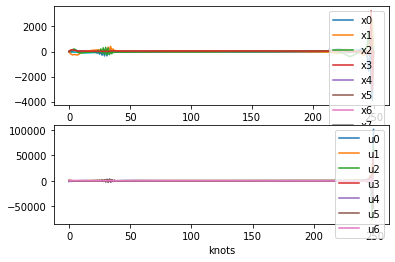

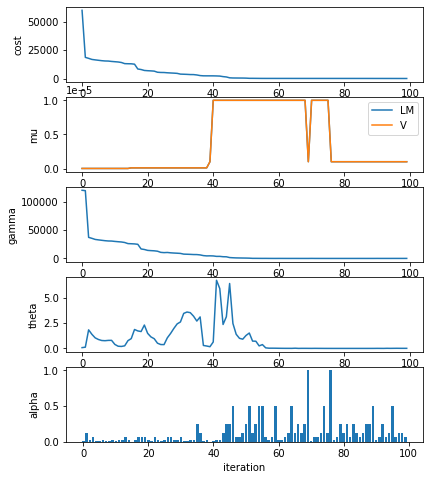

In [8]:
%matplotlib inline
# # Plotting the solution and the DDP convergence
crocoddyl.plotOCSolution(log.xs, log.us)
crocoddyl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps)

# Visualizing the solution in gepetto-viewer
display.displayFromSolver(ddp)

## III.b Multi-Contact dynamics for biped walking (Talos legs)
In crocoddyl, we can describe the multi-contact dynamics through holonomic constraints for the support legs. From the Gauss principle, we have derived the model as:
$$
\left[\begin{matrix}
 \mathbf{M} & \mathbf{J}^{\top}_c \\
 {\mathbf{J}_{c}} & \mathbf{0} \\
\end{matrix}\right]
\left[\begin{matrix}
 \dot{\mathbf{v}} \\ -\boldsymbol{\lambda}
\end{matrix}\right]
 = 
\left[\begin{matrix}
  \boldsymbol{\tau} - \mathbf{h} \\
  -\dot{\mathbf{J}}_c \mathbf{v} \\
\end{matrix}\right]$$.

This DAM is defined in "DifferentialActionModelFloatingInContact" class.

Given a predefined contact sequence and timings, we build per each phase a specific multi-contact dynamics. Indeed we need to describe multi-phase optimal control problem. One can formulate the multi-contact optimal control problem (MCOP) as follows:


$$\mathbf{X}^*,\mathbf{U}^*=
\begin{Bmatrix} \mathbf{x}^*_0,\cdots,\mathbf{x}^*_N \\
				  \mathbf{u}^*_0,\cdots,\mathbf{u}^*_N
\end{Bmatrix} =
\arg\min_{\mathbf{X},\mathbf{U}} \sum_{p=0}^P \sum_{k=1}^{N(p)} \int_{t_k}^{t_k+\Delta t} l_p(\mathbf{x},\mathbf{u})dt$$
subject to
$$ \mathbf{\dot{x}} = \mathbf{f}_p(\mathbf{x},\mathbf{u}), \text{for } t \in [\tau_p,\tau_{p+1}]$$

$$ \mathbf{g}(\mathbf{v}^{p+1},\mathbf{v}^p) = \mathbf{0}$$

$$ \mathbf{x}\in\mathcal{X}_p, \mathbf{u}\in\mathcal{U}_p, \boldsymbol{\lambda}\in\mathcal{K}_p.$$

where $\mathbf{g}(\cdot,\cdot,\cdot)$ describes the contact dynamics, and they represents terminal constraints in each walking phase. In this example we use the following impact model:

$$\mathbf{M}(\mathbf{v}_{next}-\mathbf{v}) = \mathbf{J}_{impulse}^T$$

$$\mathbf{J}_{impulse} \mathbf{v}_{next} = \mathbf{0}$$

$$\mathbf{J}_{c} \mathbf{v}_{next} = \mathbf{J}_{c} \mathbf{v}$$

### Note:
You can find an example of such kind of problems in bipedal_walking_from_foot_traj.ipynb.

## Reference

The material presented in this Notebook was previously presented at the ICRA at 2020. For more information, please read the following paper:

C. Mastalli et al. Crocoddyl: An Efficient and Versatile Framework for Multi-Contact Optimal Control, 2020

In [9]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/nTeiHioEO4w" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/david/miniconda3/envs/crocoddyl/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")




![title](https://cmastalli.github.io/assets/img/publications/astronaut360_v2.png)